# RAG over complex PDF


## Setting
 - Auto Reload
 - path for utils

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [41]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [42]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [43]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [44]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7fc3729f69b0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7fc3602cabc0>])

### Embedding 모델 선택

In [45]:
from langchain.embeddings import BedrockEmbeddings

In [46]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [47]:
import boto3
from utils.ssm import parameter_store

In [48]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [49]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [50]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [51]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: kb_complex_pdf


### OpenSearch Client 생성

In [52]:
from utils.opensearch import opensearch_utils

In [53]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [54]:
from utils.rag import qa_chain_complex_pdf
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [55]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_pdf=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [56]:
system_prompt = prompt_repo.get_system_prompt()

In [57]:
qa = qa_chain_complex_pdf(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    get_context=True,
    verbose=False
)

No relevant contexts. 주어진 문맥에는 수익률 그래프에 대한 설명이 전혀 없습니다. 화학물질 제조, 취급, 저장과 관련된 수치 목록과 비상상황 대처 매뉴얼, 안전귀가 앱 설명서 등이 있을 뿐입니다.
-----------------------------------------------
1. Category: Table, Chunk: 196 Characters
-----------------------------------------------
이 표는 다양한 수치를 나열하고 있는데, 최소 50에서 최대 750,000까지의 값을 보여주고 있습니다. 모든 항목은 "제조·취급·저장"이라는 동일한 문구를 포함하고 있습니다.
수치들의 분포를 보면 작은 값들도 있지만 50만 이상의 큰 값들이 다수 존재합니다. 이 표는 아마도 화학물질의 제조, 취급, 저장 관련 정보를 수치로 정리한 것으로 보입니다.
metadata:
 {'source': './data/complex_pdf/safety-administrator-job-manual.pdf', 'detection_class_prob':
0.793048620223999, 'coordinates': {'points': [[216.360595703125, 543.64013671875],
[216.360595703125, 1922.8236083984375], [1297.5679931640625, 1922.8236083984375],
[1297.5679931640625, 543.64013671875]], 'system': 'PixelSpace', 'layout_width': 1654,
'layout_height': 2339}, 'last_modified': '2024-03-17T06:02:18', 'filetype': 'application/pdf',
'languages': ['eng'], 'page_number': 26, 'is_continuation': True, 'file_directory':
'./data/com

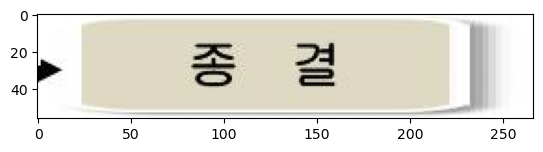

주어진 이미지는 한국어로 '종결'이라는 단어가 적힌 종이 라벨을 보여줍니다. 베이지색 바탕에 검은색 한글 글씨체로 '종결'이라고 인쇄되어 있습니다. 이는 문서나 절차의 마지막
단계를 나타내는 표시일 것으로 추측됩니다.
metadata:
 {'img_path': './fig/figure-30-53.jpg', 'category': 'Image', 'image_base64': '', 'id':
'd6bf75f9-924a-494c-84fa-c0c30f4d381f', 'origin_image': ''}

-----------------------------------------------
4. Category: Image, Chunk: 183 Characters
-----------------------------------------------


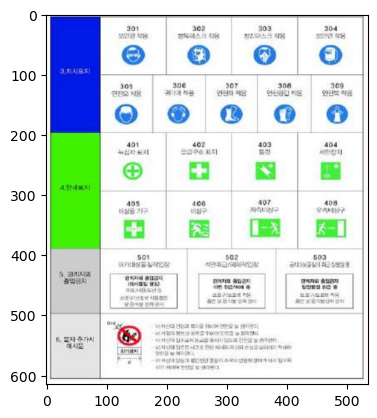

주어진 이미지는 대피소 및 비상구 표지판과 관련된 픽토그램 모음입니다. 상단에는 대피소와 관련된 픽토그램이 표시되어 있고, 가운데에는 응급 상황 시 대처 방법과 관련된 픽토그램이
있습니다. 하단에는 주의 사항과 금지 사항에 대한 설명이 있습니다. 전체적으로 비상 상황 시 대피 및 행동 요령을 알려주는 안내 표지판으로 보입니다.
metadata:
 {'img_path': './fig/figure-9-8.jpg', 'category': 'Image', 'image_base64': '', 'id':
'36e1e3c7-6b74-4852-b4b3-7736e94089ce', 'origin_image': ''}

-----------------------------------------------
5. Category: Image, Chunk: 134 Characters
-----------------------------------------------


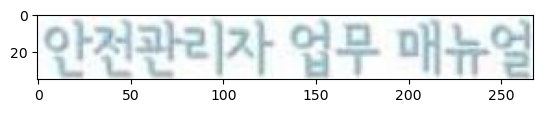

이미지는 한글로 "안전귀가 앱 매뉴얼"이라는 문구가 적혀 있습니다. 이는 안전한 귀가를 돕기 위한 모바일 애플리케이션의 사용 설명서일 것으로 보입니다. 간단명료하고 편리한
디자인으로 일반 대중들이 쉽게 이해하고 활용할 수 있을 것 같습니다.
metadata:
 {'img_path': './fig/figure-10-10.jpg', 'category': 'Image', 'image_base64': '', 'id':
'48de599d-66d5-492d-bb2d-c7af18dd2770', 'origin_image': ''}


In [58]:
query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)

### Parameter updates

In [59]:
opensearch_hybrid_retriever.update_search_params(
    k=8,
    minimum_should_match=0,
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [ ]:
query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

In [80]:
query = "산업재해 재발 방지를 위한 방법?"

response, contexts = qa.invoke(
    query = query
)

산업재해 재발방지를 위해서는 다음과 같은 방법들이 제시되어 있습니다.

(3) 산업재해 발생시 재발방지계획 수립
- 산업재해 발생 원인을 분석하고 검토한 후, 물적·인적·관리적 측면에서 구체적이고 실시 가능한 재발방지계획을 수립해야 합니다.

3. 산업재해 기록‧보존 
- 산업재해 발생시 다음 사항을 기록하고 3년간 보존해야 합니다.
③ 재해발생 원인 및 과정 
④ 재해 재발방지 계획

이를 통해 재해 원인을 파악하고 재발방지 대책을 마련하여 동종 및 유사 재해의 재발을 예방할 수 있습니다.

In [81]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts)

##################################
query:  산업재해 재발 방지를 위한 방법?
##################################


### Answer ###
산업재해 재발방지를 위해서는 다음과 같은 방법들이 제시되어 있습니다.

(3) 산업재해 발생시 재발방지계획 수립
- 산업재해 발생 원인을 분석하고 검토한 후, 물적·인적·관리적 측면에서 구체적이고 실시 가능한 재발방지계획을 수립해야 합니다.

3. 산업재해 기록‧보존
- 산업재해 발생시 다음 사항을 기록하고 3년간 보존해야 합니다.
③ 재해발생 원인 및 과정
④ 재해 재발방지 계획

이를 통해 재해 원인을 파악하고 재발방지 대책을 마련하여 동종 및 유사 재해의 재발을 예방할 수 있습니다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 216 Characters
-----------------------------------------------
(3) 산업재해 발생시 재발방지계획 수립 ○ 산업재해는 반복해서 발생하는 속성이 있기 때문에 발생한 산업재해를 분석･검토하여, 동종재해 또는 유사재해의 재발방지에 노력해야 한다.
- 산업안전보건법에서는 재해 재발방지계획을 기록 보존하도록 의무화 (산업안전보건법 제10조, 위반시 300만원 이하의 과태료 부과) ■ 산업재해 발생 원인의 분석 및 검토는
일반적으로 다음과 같은 순서로 실시
metadata:
 {'source': './data/complex_pdf/safety-administrator-job-manual.pdf', 'filetype': 'application/pdf',
'languages': ['eng'], 'last_modified': '2024-03-17T06:02:18', 'page_number': 6, 'file_directory':
'./data/complex